

---

# Intro - Autoencoder

**Plan** - Produce proof of concept autoencoder architecture.

**Purpose**: Produce a robust, flexible and stable autoencoder architecture that can be used for dimensionality reduction on input data at work. The overall purpose is to be able to use this to encode data that has thousands of features into a latent space representation with fewer (to reduce time complexity of modelling) whilst preserving predictive performance.

**Hypothesis**: with automatic HP tuning an autoencoder can be used to reduce dimensionality of input data, whilst retaining adequate information to accurately reproduce input data.

**Methodology**: Test on multiple datasets - first the Iris dataset, then Pima Indians, then finally credit card fraud dataset. Evaluate and assess model architecture and visualize latent space using PCA/UMAP etc. See below for details on evaluation methods.


# First dataset - iris dataset
---
## Data sourcing and processing


In [2]:

#import packages :

import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

from google.colab import drive

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  # Check if drive is mounted by looking for the mount point in the file system.
  # This is a more robust approach than relying on potentially internal variables.
  import os
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

#basics
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
!pip install umap-learn
!pip install optuna
from umap import UMAP
import optuna


#table one
!pip install tableone
from tableone import TableOne

#torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim  # Add this import
from torch.utils.data import Subset


#sklearn
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, random_split, Dataset
!pip install skopt
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris  # Import the Iris dataset
from sklearn.model_selection import KFold





from imblearn.over_sampling import RandomOverSampler

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt




---

# Autoencoder (Iris dataset)


1.   First we import our data and perform a dimensionality reduction (using UMAP) to see how separable the classes are. We will do the same afterwards on our latent space to check it.

2.   We will then get a Table One of the input data, and later of the reconstructed output data, to compare.

3. We will check the distribution/separation of our latent space by plotting it in 2 dimensions - therefore we will fix our latent space dimensionality HP at 2.

4. Finally as a final evaluation method we will do some basic predictive modelling on the input space vs the reconstructed data, and finally on the latent space representation.



Cuda setup successful
The dataset length is 150
The number of columns is 5
The column names are ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target'] 

Table one of input data: 
                              Grouped by target                                                    
                                        Missing    Overall          0          1          2 P-Value
n                                                      150         50         50         50        
sepal length (cm), mean (SD)                  0  5.8 (0.8)  5.0 (0.4)  5.9 (0.5)  6.6 (0.6)  <0.001
sepal width (cm), mean (SD)                   0  3.1 (0.4)  3.4 (0.4)  2.8 (0.3)  3.0 (0.3)  <0.001
petal length (cm), mean (SD)                  0  3.8 (1.8)  1.5 (0.2)  4.3 (0.5)  5.6 (0.6)  <0.001
petal width (cm), mean (SD)                   0  1.2 (0.8)  0.2 (0.1)  1.3 (0.2)  2.0 (0.3)  <0.001



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


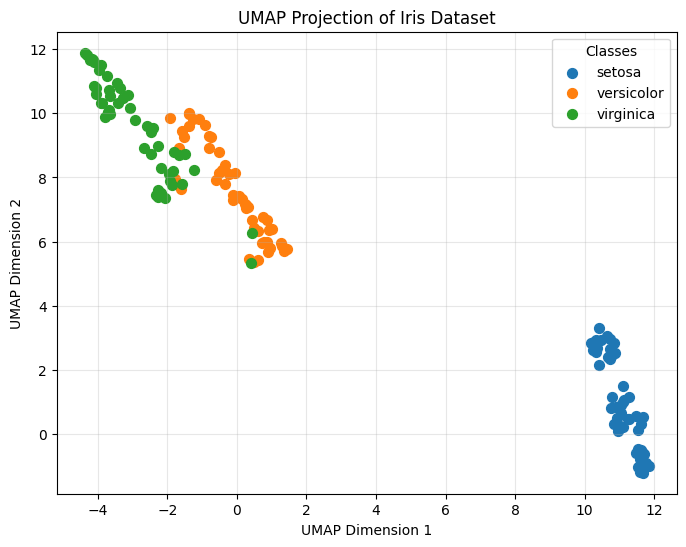

In [3]:
# **Set device for GPU acceleration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != 'cuda':
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")


#---------------- Dimensionality reduction ----------------#


# Load the Iris dataset
iris = load_iris()
data = iris.data
target = iris.target
target_names = iris.target_names

# Create a Pandas DataFrame for TableOne
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target  # Add the target column
iris_columns = iris_df.columns.tolist()

# Print dataset information and TableOne
print(f"The dataset length is {str(len(iris_df))}")
print(f"The number of columns is {str(len(iris_columns))}")
print(f"The column names are {str(iris_columns)} \n")
print("Table one of input data: ")
table1 = TableOne(iris_df, columns=iris_columns, groupby='target', pval=True)
print(table1)

# Scale the data for UMAP
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply UMAP
reducer = UMAP(n_components=2, random_state=42)
data_umap = reducer.fit_transform(data_scaled)

# Plot UMAP projection
plt.figure(figsize=(8, 6))
for class_idx, class_name in enumerate(target_names):
    plt.scatter(
        data_umap[target == class_idx, 0],
        data_umap[target == class_idx, 1],
        label=class_name,
        s=50,
    )

plt.title("UMAP Projection of Iris Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Classes")
plt.grid(True, alpha=0.3)
plt.show()


In this trial of the autoencoder, in order to get a meaningful latent space representation we are going to fix latent space dimensionality at 2, so we can compare it to our UMAP.

In [ ]:
# **Set device for GPU acceleration**

# Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")

# Load and preprocess the iris dataset
iris = load_iris()
data = iris.data

# Scale data to the range [0, 1] for better convergence
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert to PyTorch Dataset
class IrisDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = IrisDataset(data)

# split into train + validation set, to be dynamically split later
train_val_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_val_size
train_val_set, test_set = random_split(dataset, [train_val_size, test_size])

# Define Flexible Autoencoder architecture
class FlexibleAutoencoder(nn.Module):
    def __init__(self, input_dim, num_encoder_layers, encoder_neurons, num_decoder_layers, decoder_neurons, activations, dropout_prob, use_batchnorm):
        super(FlexibleAutoencoder, self).__init__()

        # Build the encoder
        encoder = []
        in_dim = input_dim

        for i in range(num_encoder_layers):
            out_dim = encoder_neurons[i] if i < num_encoder_layers - 1 else 2  # Latent space dimensionality is fixed at 2
            encoder.append(nn.Linear(in_dim, out_dim))
            if use_batchnorm and i < num_encoder_layers - 1:
                encoder.append(nn.BatchNorm1d(out_dim))
            encoder.append(getattr(nn, activations[i])())  # Use activations from encoder_activations list
            if dropout_prob > 0:
                encoder.append(nn.Dropout(dropout_prob))
            in_dim = out_dim
        self.encoder = nn.Sequential(*encoder)

        # Build the decoder
        decoder = []
        in_dim = 2  # Latent space dimensionality
        for i in range(num_decoder_layers):
            out_dim = decoder_neurons[i] if i < num_decoder_layers - 1 else input_dim  # Output layer has input_dim neurons
            decoder.append(nn.Linear(in_dim, out_dim))
            if use_batchnorm and i < num_decoder_layers - 1:
                decoder.append(nn.BatchNorm1d(out_dim))
            decoder.append(getattr(nn, activations[num_encoder_layers + i])())  # Use activations from decoder_activations list
            if dropout_prob > 0 and i < num_decoder_layers - 1:
                decoder.append(nn.Dropout(dropout_prob))
            in_dim = out_dim
        self.decoder = nn.Sequential(*decoder)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed


# Training and evaluation functions
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    model.to(device)  # Move model to the correct device (GPU or CPU)

    # Lists to track the loss for each epoch
    train_loss_history = []
    val_loss_history = []

    # Loop over the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0

        # Training loop
        for batch in train_loader:
            batch = batch.to(device)  # Move batch to the device
            optimizer.zero_grad()  # Zero out the gradients
            latent, reconstructed = model(batch)  # Get model outputs # unpack output tuple here
            loss = criterion(reconstructed, batch)  # Calculate the loss using reconstructed output
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters

            total_train_loss += loss.item()  # Accumulate the training loss

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0.0

        with torch.no_grad():  # No gradients needed for validation
            for batch in val_loader:
                batch = batch.to(device)  # Move batch to the device
                latent, reconstructed = model(batch) # unpack output tuple here
                loss = criterion(reconstructed, batch)  # Calculate the loss using reconstructed output
                total_val_loss += loss.item()  # Accumulate the validation loss

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

    return train_loss_history, val_loss_history

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            _, outputs = model(batch)  # Unpack the output tuple, using only the reconstructed output
            loss = criterion(outputs, batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# K-Fold Cross-Validation with Optuna
from sklearn.model_selection import KFold
import torch.optim as optim

# K-Fold Cross-Validation with Optuna
def objective(trial):
    # Number of encoder and decoder layers
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 2, 5)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 2, 5)

    # List of possible activation functions
    activation_choices = ["ReLU", "Tanh", "LeakyReLU", "Sigmoid"]

    # Vary the number of neurons for each encoder and decoder layer
    encoder_neurons = []
    decoder_neurons = []

    for i in range(num_encoder_layers):
        encoder_neurons.append(trial.suggest_int(f"encoder_neurons_{i}", 16, 128, step=16))

    for i in range(num_decoder_layers):
        decoder_neurons.append(trial.suggest_int(f"decoder_neurons_{i}", 16, 128, step=16))

    activations = [trial.suggest_categorical(f"encoder_activation_{i}", activation_choices) for i in range(num_encoder_layers)]
    activations += [trial.suggest_categorical(f"decoder_activation_{i}", activation_choices) for i in range(num_decoder_layers)]

    # Set dropout and batch normalization parameters
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.5)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])

    # Suggest batch_size to Optuna:
    batch_size = trial.suggest_int("batch_size", 16, 64) # Suggest batch sizes between 16 and 64

    # Create the model
    model = FlexibleAutoencoder(
        input_dim=data.shape[1],
        num_encoder_layers=num_encoder_layers,
        encoder_neurons=encoder_neurons,
        num_decoder_layers=num_decoder_layers,
        decoder_neurons=decoder_neurons,
        activations=activations,
        dropout_prob=dropout_prob,
        use_batchnorm=use_batchnorm
    )

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_loguniform("lr", 1e-5, 1e-1))
    criterion = torch.nn.MSELoss()  # Using MSE loss as it's an autoencoder

    # K-Fold Cross Validation
    kfold = KFold(n_splits=5, shuffle=True)
    fold_losses = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_val_set)):
        # Create train and validation datasets for this fold
        train_subset = torch.utils.data.Subset(train_val_set, train_idx)
        val_subset = torch.utils.data.Subset(train_val_set, val_idx)

        # DataLoader for the current fold
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last = True) # Use suggested batch_size
        val_batch_size = min(batch_size, len(val_subset)) # Ensure val_batch_size <= validation set size
        val_loader = DataLoader(val_subset, batch_size=val_batch_size, shuffle=False, drop_last = False) # Use suggested batch_size

        # Train the model for the current fold
        train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50)

        # Calculate the average validation loss for the fold
        fold_losses.append(val_loss_history[-1])  # Get last epoch's validation loss

    # Return the average loss across all folds
    avg_fold_loss = sum(fold_losses) / len(fold_losses)

    return avg_fold_loss


# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

# Evaluate on holdout test set
# Evaluate on holdout test set
best_params = study.best_params
num_encoder_layers = best_params["num_encoder_layers"]
num_decoder_layers = best_params["num_decoder_layers"]

# Extract encoder and decoder neurons based on the number of layers
encoder_neurons = [best_params[f"encoder_neurons_{i}"] for i in range(num_encoder_layers)]
decoder_neurons = [best_params[f"decoder_neurons_{i}"] for i in range(num_decoder_layers)]

# Extract activation functions based on the number of layers
activations = [best_params[f"encoder_activation_{i}"] for i in range(num_encoder_layers)]
activations += [best_params[f"decoder_activation_{i}"] for i in range(num_decoder_layers)]

final_model = FlexibleAutoencoder(
    input_dim=data.shape[1],
    num_encoder_layers=num_encoder_layers,
    encoder_neurons=encoder_neurons,  # Use the extracted encoder_neurons
    num_decoder_layers=num_decoder_layers,
    decoder_neurons=decoder_neurons,  # Use the extracted decoder_neurons
    activations=activations,  # Use the extracted activations
    dropout_prob=best_params["dropout_prob"],
    use_batchnorm=best_params["use_batchnorm"],
).to(device)

test_loader = DataLoader(test_set, batch_size=best_params["batch_size"])
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
criterion = nn.MSELoss()

# Train final model
train_model(final_model, DataLoader(train_val_set, batch_size=best_params["batch_size"], shuffle=True), test_loader, optimizer, criterion) # Added test_loader as the validation loader here

# Evaluate on the test set
test_loss = evaluate(final_model, test_loader, criterion)
print("Test loss on holdout set:", test_loss)


[I 2024-12-13 17:05:07,715] A new study created in memory with name: no-name-963b6035-cf00-4669-9d7c-7debf5675d3d


Cuda setup successful


<ipython-input-27-62070ad59d81>:178: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer = optim.Adam(model.parameters(), lr=trial.suggest_loguniform("lr", 1e-5, 1e-1))
[I 2024-12-13 17:05:09,219] Trial 0 finished with value: 0.006045402772724628 and parameters: {'num_encoder_layers': 2, 'num_decoder_layers': 3, 'encoder_neurons_0': 48, 'encoder_neurons_1': 16, 'decoder_neurons_0': 128, 'decoder_neurons_1': 32, 'decoder_neurons_2': 128, 'encoder_activation_0': 'Tanh', 'encoder_activation_1': 'Tanh', 'decoder_activation_0': 'LeakyReLU', 'decoder_activation_1': 'Tanh', 'decoder_activation_2': 'Tanh', 'dropout_prob': 0.07777980122737599, 'use_batchnorm': False, 'batch_size': 46, 'lr': 0.003411791943939828}. Best is trial 0 with value: 0.006045402772724628.
[I 2024-12-13 17:05:10,666] Trial 1 finished with value: 0.006010814942

Now let's visualize our latent space representation to compare it to our UMAP - this will allow us to see how well the data is clustered. TO DO



---

# Auto push to github




In [ ]:
import datetime
import os

def commit_to_github(commit_msg):
  """
  Funct to autopush to github
  """

  # Navigate to the repository directory
  %cd /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice

  !git add .

  with open('/content/drive/MyDrive/IAM/PAT.txt', 'r') as file:
        github_pat = file.read().strip()
  os.environ['GITHUB_PAT'] = github_pat

  !git remote add origin "https://github.com/archiegoodman2/machine_learning_practice"

  # Replace with your actual username and email
  USERNAME="archiegoodman2"
  EMAIL="archiegoodman2011@gmail.com"

  # Set global username and email configuration
  !git config --global user.name "$USERNAME"
  !git config --global user.email "$EMAIL"

  now = datetime.datetime.now()
  current_datetime = now.strftime("%Y-%m-%d %H:%M")

  # Set remote URL using the PAT from environment variable
  !git remote set-url origin https://{os.environ['GITHUB_PAT']}@github.com/archiegoodman2/machine_learning_practice.git

  # Replace with your desired commit message
  COMMIT_MESSAGE = str(current_datetime) + " " + str(commit_msg)

  # Commit the changes
  !git commit -m "$COMMIT_MESSAGE"

  # Push to origin (force push if necessary)
  !git push origin master

  return 1

commit_to_github("added kfold cross validation. added flexible number of neurons for each individual layer.")
